In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
from tqdm import tqdm
import random
import math
from IPython.display import HTML

from maps_helper import *

%load_ext autoreload
%autoreload 2

(tensor(-25.3284, device='cuda:0'), tensor(-5.5359, device='cuda:0'))

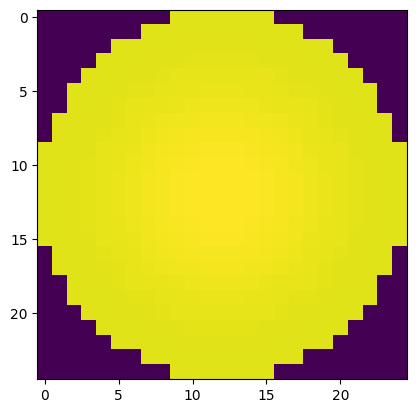

In [418]:
V1_SIZE = 100
UNITS = 21 # should be odd
DIAMETER = 25 # should be odd
SHARPNESS = 0.5
C = 0.
DECO_DIAMETER = oddenise(round(DIAMETER*3))

#SPATIAL_SCALE = 3
cutoff = get_circle(DIAMETER, DIAMETER/2)
radius_mask = get_radial_cos(DIAMETER, DIAMETER/2)
radius_mask = torch.exp(radius_mask * SHARPNESS) * cutoff
radius_mask /= torch.max(radius_mask)
radius_mask += C
radius_mask /= torch.sum(radius_mask)
radius_mask = torch.log(radius_mask + 1e-11)
#decorrelation_mask *= radius_mask.max() - radius_mask

#vm_mask = (torch.exp(get_radial_cos(DIAMETER, DIAMETER/2)) + 0./DIAMETER**2) * cutoff
vm_mask = torch.exp(get_radial_cos(DIAMETER, DIAMETER/2)) #* cutoff
#vm_mask = get_gaussian(DIAMETER, DIAMETER/5) * cutoff
    
#cutoff = ~get_circle(DECO_DIAMETER, DIAMETER*1.5)
deco_cutoff = get_circle(DECO_DIAMETER, DECO_DIAMETER/2)
r = (DECO_DIAMETER-DIAMETER)//2
#deco_cutoff[:,:,r:-r,r:-r] *= ~cutoff
#decorrelation_mask = ((get_radial_cos(DECO_DIAMETER, DIAMETER))) * deco_cutoff 
#decorrelation_mask = torch.relu(-get_radial_cos(DECO_DIAMETER, DIAMETER))
decorrelation_mask = get_linear(DECO_DIAMETER)# * deco_cutoff
#decorrelation_mask[:,:,r:-r,r:-r] *= 1 - radius_mask

radius_mask = radius_mask.view(1,-1,1).cuda()
#radius_mask /= radius_mask.sum()

decorrelation_mask = decorrelation_mask.view(1,-1,1).cuda()
decorrelation_mask /= decorrelation_mask.sum()

vm_mask = vm_mask.view(1,-1,1).cuda() 
#m_mask /= vm_mask.sum()
vm_mask /= vm_mask.max()

cutoff = cutoff.view(1,-1,1).cuda() 
deco_cutoff = deco_cutoff.view(1,-1,1).cuda() 

plt.imshow(radius_mask.view(DIAMETER, DIAMETER).cpu())
radius_mask.min(), radius_mask.max()

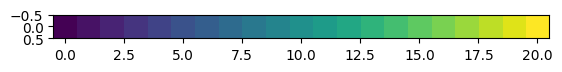

In [419]:
shifter = torch.arange(UNITS)[None,:,None, None]
prior = (shifter - UNITS//2) * (2*torch.pi/(UNITS))
plt.imshow(prior[:,:,0,0])
plt.show()
prior = prior.cuda()
shifter = shifter.cuda()

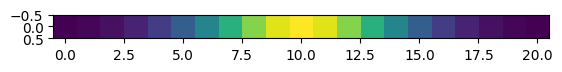

tensor([[[0.0140, 0.0153, 0.0181, 0.0228, 0.0301, 0.0405, 0.0542, 0.0702,
          0.0859, 0.0978, 0.1022, 0.0978, 0.0859, 0.0702, 0.0542, 0.0405,
          0.0301, 0.0228, 0.0181, 0.0153, 0.0140]]], device='cuda:0')


In [420]:
k = 1
c = 0./UNITS
target_distribution = prior.view(-1)
target_distribution = torch.cos(target_distribution)[None,None]
target_distribution -= target_distribution.min()
target_distribution = torch.softmax(target_distribution*k, dim=2)
target_distribution += c
target_distribution = target_distribution / target_distribution.sum()
plt.imshow(target_distribution[0].cpu())
plt.show()
print(target_distribution)

In [432]:
EPOCHS = 10000
SAMPLE_FREQ = 100
TAU = 0.1 # best value out of statistical testing
SYMMETRY = False

loss_tracker = torch.zeros(EPOCHS)
angles_tracker = torch.zeros((EPOCHS//SAMPLE_FREQ, V1_SIZE, V1_SIZE))
magnit_tracker = torch.zeros((EPOCHS//SAMPLE_FREQ, V1_SIZE, V1_SIZE))
neurons = torch.rand((1, 1, V1_SIZE, V1_SIZE), dtype=torch.float32) 
neurons = (neurons*2-1) * torch.pi
magnitudes = torch.ones(neurons.shape)
neurons = nn.Parameter(neurons.cuda())
magnitudes = nn.Parameter(magnitudes.cuda())
optimiser = torch.optim.SGD([neurons, magnitudes], lr=0.1)

unit_dist = torch.ones(UNITS)
unit_dist = unit_dist.view(1,-1,1).cuda()
unit_dist /= unit_dist.sum()


#log = get_log(DIAMETER, DIAMETER/7).view(cutoff.shape).cuda() * cutoff
#plt.imshow(log.view(DIAMETER, DIAMETER).cpu())
#plt.show()
#log -= log.mean()
#print(log.sum())

def wiring_loss(neurons, i, e, tau):
            
    q = (1 - i/e)**2
    q *= 0.3
    mags = torch.sigmoid(magnitudes)
    noise = torch.randn((1,1,V1_SIZE**2), device=neurons.device) * torch.pi

    if False:
        q = 1 - i/e
        q *= 0.

        ang_distributions = torch.cos(prior - neurons)
        ang_distributions = F.log_softmax(ang_distributions, dim=1)
        gumbel_noise = torch.rand(ang_distributions.shape, device=ang_distributions.device)
        gumbel_noise = -torch.log(-torch.log(gumbel_noise+1e-7)+1e-7)
        neurons_onehot = torch.softmax((ang_distributions+gumbel_noise*q)/tau, dim=1)

        offset_distributions = neurons_onehot.detach().permute(2,3,0,1).view(V1_SIZE**2,1,UNITS)
        offset_distributions = F.pad(offset_distributions, (UNITS//2,UNITS//2), mode='circular').float()
        offset_distributions = F.conv1d(offset_distributions, target_distribution)

        neurons_onehot = neurons_onehot * mags
        
        r = DIAMETER//2
        onehot_tiles = F.pad(neurons_onehot, (r,r,r,r), mode='circular')
        onehot_tiles = F.unfold(onehot_tiles, kernel_size=DIAMETER).view(UNITS, DIAMETER**2, -1)           
        neigh_distribution = (onehot_tiles * radius_mask).sum(1,keepdim=True)
        neigh_distribution = neigh_distribution / (neigh_distribution.detach().sum(0,keepdim=True)+1e-7)

        #if SYMMETRY:
        #    ori_shifts = (neurons_onehot.argmax(1, keepdim=True) - UNITS//2)
        #    ori_shifts = shifter.expand(-1,-1,V1_SIZE, V1_SIZE) - ori_shifts*2
        #    ori_shifts = ori_shifts % UNITS
        #    neigh_reverse = neigh_distribution.flip(dims=[0]).view(ori_shifts.shape)
        #    neigh_reverse = neigh_reverse.gather(1, ori_shifts).view(neigh_distribution.shape)
        #    neigh_distribution = (neigh_distribution + neigh_reverse) / 2

        neigh_distribution = neigh_distribution.permute(2,1,0)
        connectome_loss = ((neigh_distribution - offset_distributions)**2).sum()
        
    r = DIAMETER//2
    corr_angs = neurons
    ang_tiles = F.pad(corr_angs, (r,r,r,r), mode='circular')
    ang_tiles = F.unfold(ang_tiles, kernel_size=DIAMETER).view(1, DIAMETER**2, -1)
    mag_tiles = F.pad(mags, (r,r,r,r), mode='circular')
    mag_tiles = F.unfold(mag_tiles, kernel_size=DIAMETER).view(1, DIAMETER**2, -1)
    ang_tiles = torch.cos(ang_tiles.detach() - corr_angs.view(1,1,-1) + noise*q) * mags.detach().view(1,1,-1) * mag_tiles.detach()
    ang_tiles = torch.exp(ang_tiles) * cutoff + 1e-9
    ang_tiles = ang_tiles / ang_tiles.detach().sum(1, keepdim=True)
    corr = F.kl_div(radius_mask, ang_tiles, reduction='none')
    #corr = corr * cutoff
    #corr = corr.sum(1, keepdim=True)
    #corr_w = corr.detach()
    #corr_w = corr_w / corr_w.mean()
    #corr = corr * corr_w
    corr_loss = corr.sum() * 4 / np.pi
    #plastic_mask = plastic_mask / plastic_mask.sum(1, keepdim=True)
    #plt.imshow(plastic_mask[0,:,100].view(DECO_DIAMETER, DECO_DIAMETER).detach().cpu())
    #plt.show()
    #plt.imshow(ang_tiles_large[0,:,100].view(DECO_DIAMETER, DECO_DIAMETER).detach().cpu())
    #plt.show()
    #print(ang_tiles_large[0,:,100])
    #corr_loss = corr.sum()
    
    #corr_weights = (corr_loss.detach() - corr_loss.detach().mean())
    
    #corr_loss = (corr_loss * lw_pos).sum()
    #corr_std = torch.sum((corr_loss - corr_loss.mean())**2)
    #corr_loss = corr_loss.sum()
    #corr_loss = (ang_tiles * plastic_mask).sum()

    r = DECO_DIAMETER//2

    #sampled_angs = neurons_onehot.argmax(1,keepdim=True)
    #sampled_angs = prior.expand(-1,-1,V1_SIZE, V1_SIZE).gather(1, sampled_angs)
    #sampled_angs = neurons
    #ang_tiles_large = F.pad(sampled_angs, (r,r,r,r), mode='constant')
    #ang_tiles_large = F.unfold(ang_tiles_large, kernel_size=DECO_DIAMETER).view(1, DECO_DIAMETER**2, -1)
    #mag_tiles_large = F.pad(mags, (r,r,r,r), mode='constant')
    #mag_tiles_large = F.unfold(mag_tiles_large, kernel_size=DECO_DIAMETER).view(1, DECO_DIAMETER**2, -1)
    #sampled_angs = sampled_angs.view(1,1,-1)
    #mags = mags.view(1,1,-1)
    #ang_tiles_large = torch.cos(ang_tiles_large.detach() - sampled_angs + noise*q) * mags * mag_tiles_large.detach()
    #ang_tiles_large = torch.exp(ang_tiles_large) / (torch.e)
    #plastic_mask = decorrelation_mask * ang_tiles_large.detach()**S
    #plastic_mask = plastic_mask / plastic_mask.sum(1, keepdim=True)
    #plt.imshow(plastic_mask[0,:,100].view(DECO_DIAMETER, DECO_DIAMETER).detach().cpu())
    #plt.show()
    #plt.imshow(ang_tiles_large[0,:,100].view(DECO_DIAMETER, DECO_DIAMETER).detach().cpu())
    #plt.show()
    #print(ang_tiles_large[0,:,100])
    #deco_loss = -plastic_mask.sum() #/ deco_cutoff.sum()
    #deco_loss = (ang_tiles_large * plastic_mask).sum()
#
        
        #onehot_tiles_large = F.pad(neurons_onehot, (r,r,r,r), mode='circular')
        #onehot_tiles_large = F.unfold(onehot_tiles_large, kernel_size=DECO_DIAMETER).view(UNITS, DECO_DIAMETER**2, -1)
        #deco_distribution = (onehot_tiles_large * plastic_mask).sum(1,keepdim=True)
        #deco_distribution = deco_distribution / (deco_distribution.detach().sum(0,keepdim=True)+1e-7)
        #deco_distribution = deco_distribution.permute(2,1,0)
        #deco_loss = ((deco_distribution - offset_distributions)**2).sum()
        

    #plastic_mask = plastic_mask / plastic_mask.sum(1, keepdim=True)
    #plt.imshow(plastic_mask[0,:,100].view(DECO_DIAMETER, DECO_DIAMETER).detach().cpu())
    #plt.show()
    #plt.imshow(ang_tiles_large[0,:,100].view(DECO_DIAMETER, DECO_DIAMETER).detach().cpu())
    #plt.show()
    #print(ang_tiles_large[0,:,100])
    #corr_loss = corr.sum()
    #corr_loss = (ang_tiles * plastic_mask).sum()


    #r = DIAMETER//2
    #noise = torch.randn(neurons.shape, device=neurons.device) * 0
    #noise = random.random()*torch.pi*2
    #noise += i/2000 * torch.pi*2
    
    #neuron_tiles = F.pad(neurons, (r,r,r,r), mode='circular')
    #neuron_tiles = F.unfold(neuron_tiles, kernel_size=DIAMETER).view(1, DIAMETER**2, V1_SIZE, V1_SIZE)   
    
    #mags = torch.sigmoid(magnitudes)
    
    #mag_tiles = F.pad(mags, (r,r,r,r), mode='circular')
    #mag_tiles = F.unfold(mag_tiles, kernel_size=DIAMETER).view(1, DIAMETER**2, V1_SIZE, V1_SIZE) 
    
    #neuron_tiles = torch.cos(neuron_tiles) * mags * mag_tiles + noise
    #neuron_tiles = torch.exp(neuron_tiles) / torch.e

    #neuron_tiles = neuron_tiles.view(1, DIAMETER**2, -1)
    #neuron_tiles = neuron_tiles * cutoff
    
    #smoothness = ((log*neuron_tiles)**2).sum()
    
    #corr_prior = ((neuron_tiles - vm_mask)**2).sum(1)
    #corr_prior = corr_prior.sum() / cutoff.sum() 
    
    #corr_prior = - (normalise(neuron_tiles, dims=1) * normalise(vm_mask, dims=1)).sum(1)
    
    #sameness = ((corr_prior - corr_prior.mean())**2).sum()
    
    #corr_prior = corr_prior.sum()
    
    if False:
        r = DECO_DIAMETER//2
        neuron_tiles_large = F.pad(neurons, (r,r,r,r), mode='circular')
        neuron_tiles_large = F.unfold(neuron_tiles_large, kernel_size=DECO_DIAMETER).view(1, DECO_DIAMETER**2, V1_SIZE, V1_SIZE)    

        mag_tiles_large = F.pad(mags, (r,r,r,r), mode='circular')
        mag_tiles_large = F.unfold(mag_tiles_large, kernel_size=DECO_DIAMETER).view(1, DECO_DIAMETER**2, V1_SIZE, V1_SIZE)    

        neuron_tiles_large = torch.cos(neurons - neuron_tiles_large) * mags * mag_tiles_large
        neuron_tiles_large = torch.exp(neuron_tiles_large) / torch.e

        neuron_tiles_large = neuron_tiles_large.view(1, DECO_DIAMETER**2, -1)
        neuron_tiles_large = neuron_tiles_large * deco_cutoff        
        plastic_mask = decorrelation_mask.repeat(1,1,V1_SIZE**2)
        plastic_mask *= neuron_tiles_large.detach()
        plastic_mask /= plastic_mask.sum(1, keepdim=True)

        decorrelation = (neuron_tiles_large * plastic_mask).sum(1, keepdim=True)
        print(corr.shape)
    
    #ang_distributions = torch.softmax(torch.cos(prior - neurons), dim=1) / torch.e
    #indices = F.one_hot(ang_distributions.argmax(1), num_classes=UNITS).permute(0,3,1,2)
    #ang_distributions = (ang_distributions * indices).mean([0,2,3])
    #target = ang_distributions.detach().mean()
    #completeness = ((ang_distributions - target)**2).sum()
    
    
    #G = (corr_loss.detach() - corr_loss.detach().mean()) + 0.5
    #G = torch.relu(G)
          
    loss = corr_loss #- 3e-2*magnitudes.sum()
    loss = loss.sum()
    
    #loss_weights = loss.detach() - loss.detach().mean()*10 + 1
    
    #loss = (loss * loss_weights).sum()
    
    return loss


In [433]:
G = 1

In [434]:
for i in tqdm(range(EPOCHS)):
    
    with torch.no_grad():
        neurons %= torch.pi*2
        
    loss = wiring_loss(neurons, i, EPOCHS, TAU)
    loss_tracker[i] = loss.detach().cpu()
    
    if i%SAMPLE_FREQ==0:
        angles_tracker[i//SAMPLE_FREQ] = neurons.detach().cpu()[0,0]
        magnit_tracker[i//SAMPLE_FREQ] = magnitudes.detach().cpu()[0,0]

    optimiser.zero_grad()
    loss.backward()
            
    optimiser.step()

100%|████████████████████████████████████| 10000/10000 [00:29<00:00, 337.31it/s]


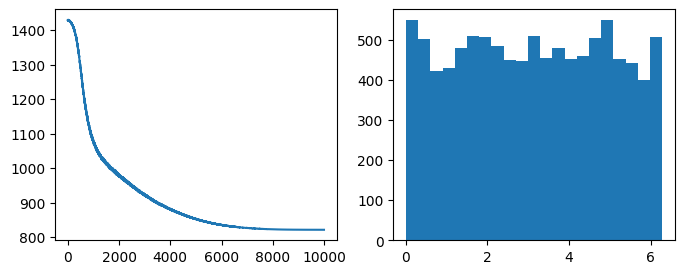

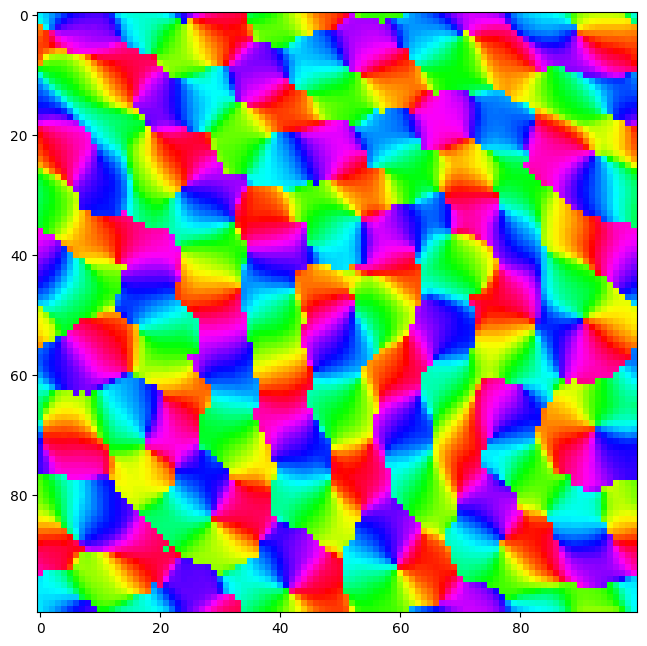

In [435]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(loss_tracker)

plt.subplot(1,2,2)
values = neurons.detach().flatten().cpu()
plt.hist(values, bins=UNITS)
array = angles_tracker
anim = animate(array, array.shape[0], cmap='hsv', interval=100)
anim = anim.to_jshtml()
HTML(anim)

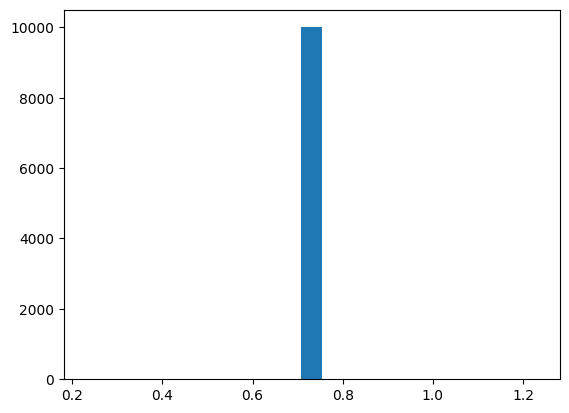

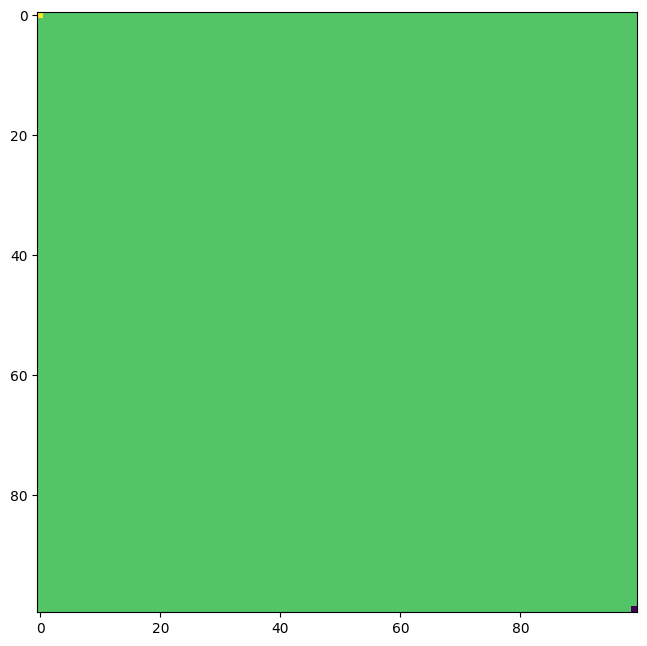

In [436]:
values = torch.sigmoid(magnitudes.detach().flatten().cpu())
plt.hist(values, bins=UNITS)
array = torch.sigmoid(magnit_tracker)
array[:,0,0] = 1
array[:,-1,-1] = 0
anim = animate(array, array.shape[0], interval=100)
anim = anim.to_jshtml()
HTML(anim)